In [1]:
# 导入相关包
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.rc('font', family='SimHei', size=13)

import os,gc,re,warnings,sys
warnings.filterwarnings("ignore")

In [2]:
# 读取数据
path = './data_raw/'

#####train
trn_click = pd.read_csv(path+'train_click_log.csv')
item_df = pd.read_csv(path+'articles.csv')
item_df = item_df.rename(columns={'article_id': 'click_article_id'})  #重命名，方便后续match
item_emb_df = pd.read_csv(path+'articles_emb.csv')

#####test
tst_click = pd.read_csv(path+'testA_click_log.csv')

In [3]:
# 数据预处理

# 对每个用户的点击时间戳进行排序
trn_click['rank'] = trn_click.groupby(['user_id'])['click_timestamp'].rank(ascending=False).astype(int)
tst_click['rank'] = tst_click.groupby(['user_id'])['click_timestamp'].rank(ascending=False).astype(int)

#计算用户点击文章的次数，并添加新的一列count
trn_click['click_cnts'] = trn_click.groupby(['user_id'])['click_timestamp'].transform('count')
tst_click['click_cnts'] = tst_click.groupby(['user_id'])['click_timestamp'].transform('count')

In [4]:
# 用户点击日志文件_训练集
trn_click = trn_click.merge(item_df, how='left', on=['click_article_id'])
trn_click.head()

,user_id,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type,rank,click_cnts,category_id,created_at_ts,words_count
0,199999,160417,1507029570190,4,1,17,1,13,1,11,11,281,1506942089000,173
1,199999,5408,1507029571478,4,1,17,1,13,1,10,11,4,1506994257000,118
2,199999,50823,1507029601478,4,1,17,1,13,1,9,11,99,1507013614000,213
3,199998,157770,1507029532200,4,1,17,1,25,5,40,40,281,1506983935000,201
4,199998,96613,1507029671831,4,1,17,1,25,5,39,40,209,1506938444000,185


In [5]:
#用户点击日志信息
trn_click.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1112623 entries, 0 to 1112622
Data columns (total 14 columns):
 #   Column               Non-Null Count    Dtype
---  ------               --------------    -----
 0   user_id              1112623 non-null  int64
 1   click_article_id     1112623 non-null  int64
 2   click_timestamp      1112623 non-null  int64
 3   click_environment    1112623 non-null  int64
 4   click_deviceGroup    1112623 non-null  int64
 5   click_os             1112623 non-null  int64
 6   click_country        1112623 non-null  int64
 7   click_region         1112623 non-null  int64
 8   click_referrer_type  1112623 non-null  int64
 9   rank                 1112623 non-null  int32
 10  click_cnts           1112623 non-null  int64
 11  category_id          1112623 non-null  int64
 12  created_at_ts        1112623 non-null  int64
 13  words_count          1112623 non-null  int64
dtypes: int32(1), int64(13)
memory usage: 114.6 MB


In [6]:
trn_click.describe()

,user_id,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type,rank,click_cnts,category_id,created_at_ts,words_count
count,1.112623e+06,1.112623e+06,1.112623e+06,1.112623e+06,1.112623e+06,1.112623e+06,1.112623e+06,1.112623e+06,1.112623e+06,1.112623e+06,1.112623e+06,1.112623e+06,1.112623e+06,1.112623e+06
mean,1.221198e+05,1.951541e+05,1.507588e+12,3.947786e+00,1.815981e+00,1.301976e+01,1.310776e+00,1.813587e+01,1.910063e+00,7.118518e+00,1.323704e+01,3.056176e+02,1.506598e+12,2.011981e+02
std,5.540349e+04,9.292286e+04,3.363466e+08,3.276715e-01,1.035170e+00,6.967844e+00,1.618264e+00,7.105832e+00,1.220012e+00,1.016095e+01,1.631503e+01,1.155791e+02,8.343066e+09,5.223881e+01
min,0.000000e+00,3.000000e+00,1.507030e+12,1.000000e+00,1.000000e+00,2.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,2.000000e+00,1.000000e+00,1.166573e+12,0.000000e+00
25%,7.934700e+04,1.239090e+05,1.507297e+12,4.000000e+00,1.000000e+00,2.000000e+00,1.000000e+00,1.300000e+01,1.000000e+00,2.000000e+00,4.000000e+00,2.500000e+02,1.507220e+12,1.700000e+02
50%,1.309670e+05,2.038900e+05,1.507596e+12,4.000000e+00,1.000000e+00,1.700000e+01,1.000000e+00,2.100000e+01,2.000000e+00,4.000000e+00,8.000000e+00,3.280000e+02,1.507553e+12,1.970000e+02
75%,1.704010e+05,2.777120e+05,1.507841e+12,4.000000e+00,3.000000e+00,1.700000e+01,1.000000e+00,2.500000e+01,2.000000e+00,8.000000e+00,1.600000e+01,4.100000e+02,1.507756e+12,2.280000e+02
max,1.999990e+05,3.640460e+05,1.510603e+12,4.000000e+00,5.000000e+00,2.000000e+01,1.100000e+01,2.800000e+01,7.000000e+00,2.410000e+02,2.410000e+02,4.600000e+02,1.510666e+12,6.690000e+03


In [7]:
#训练集中的用户数量为20w
trn_click.user_id.nunique()

200000

In [8]:
trn_click.groupby('user_id')['click_article_id'].count().min()  # 训练集里面每个用户至少点击了两篇文章

2

<Figure size 640x480 with 0 Axes>

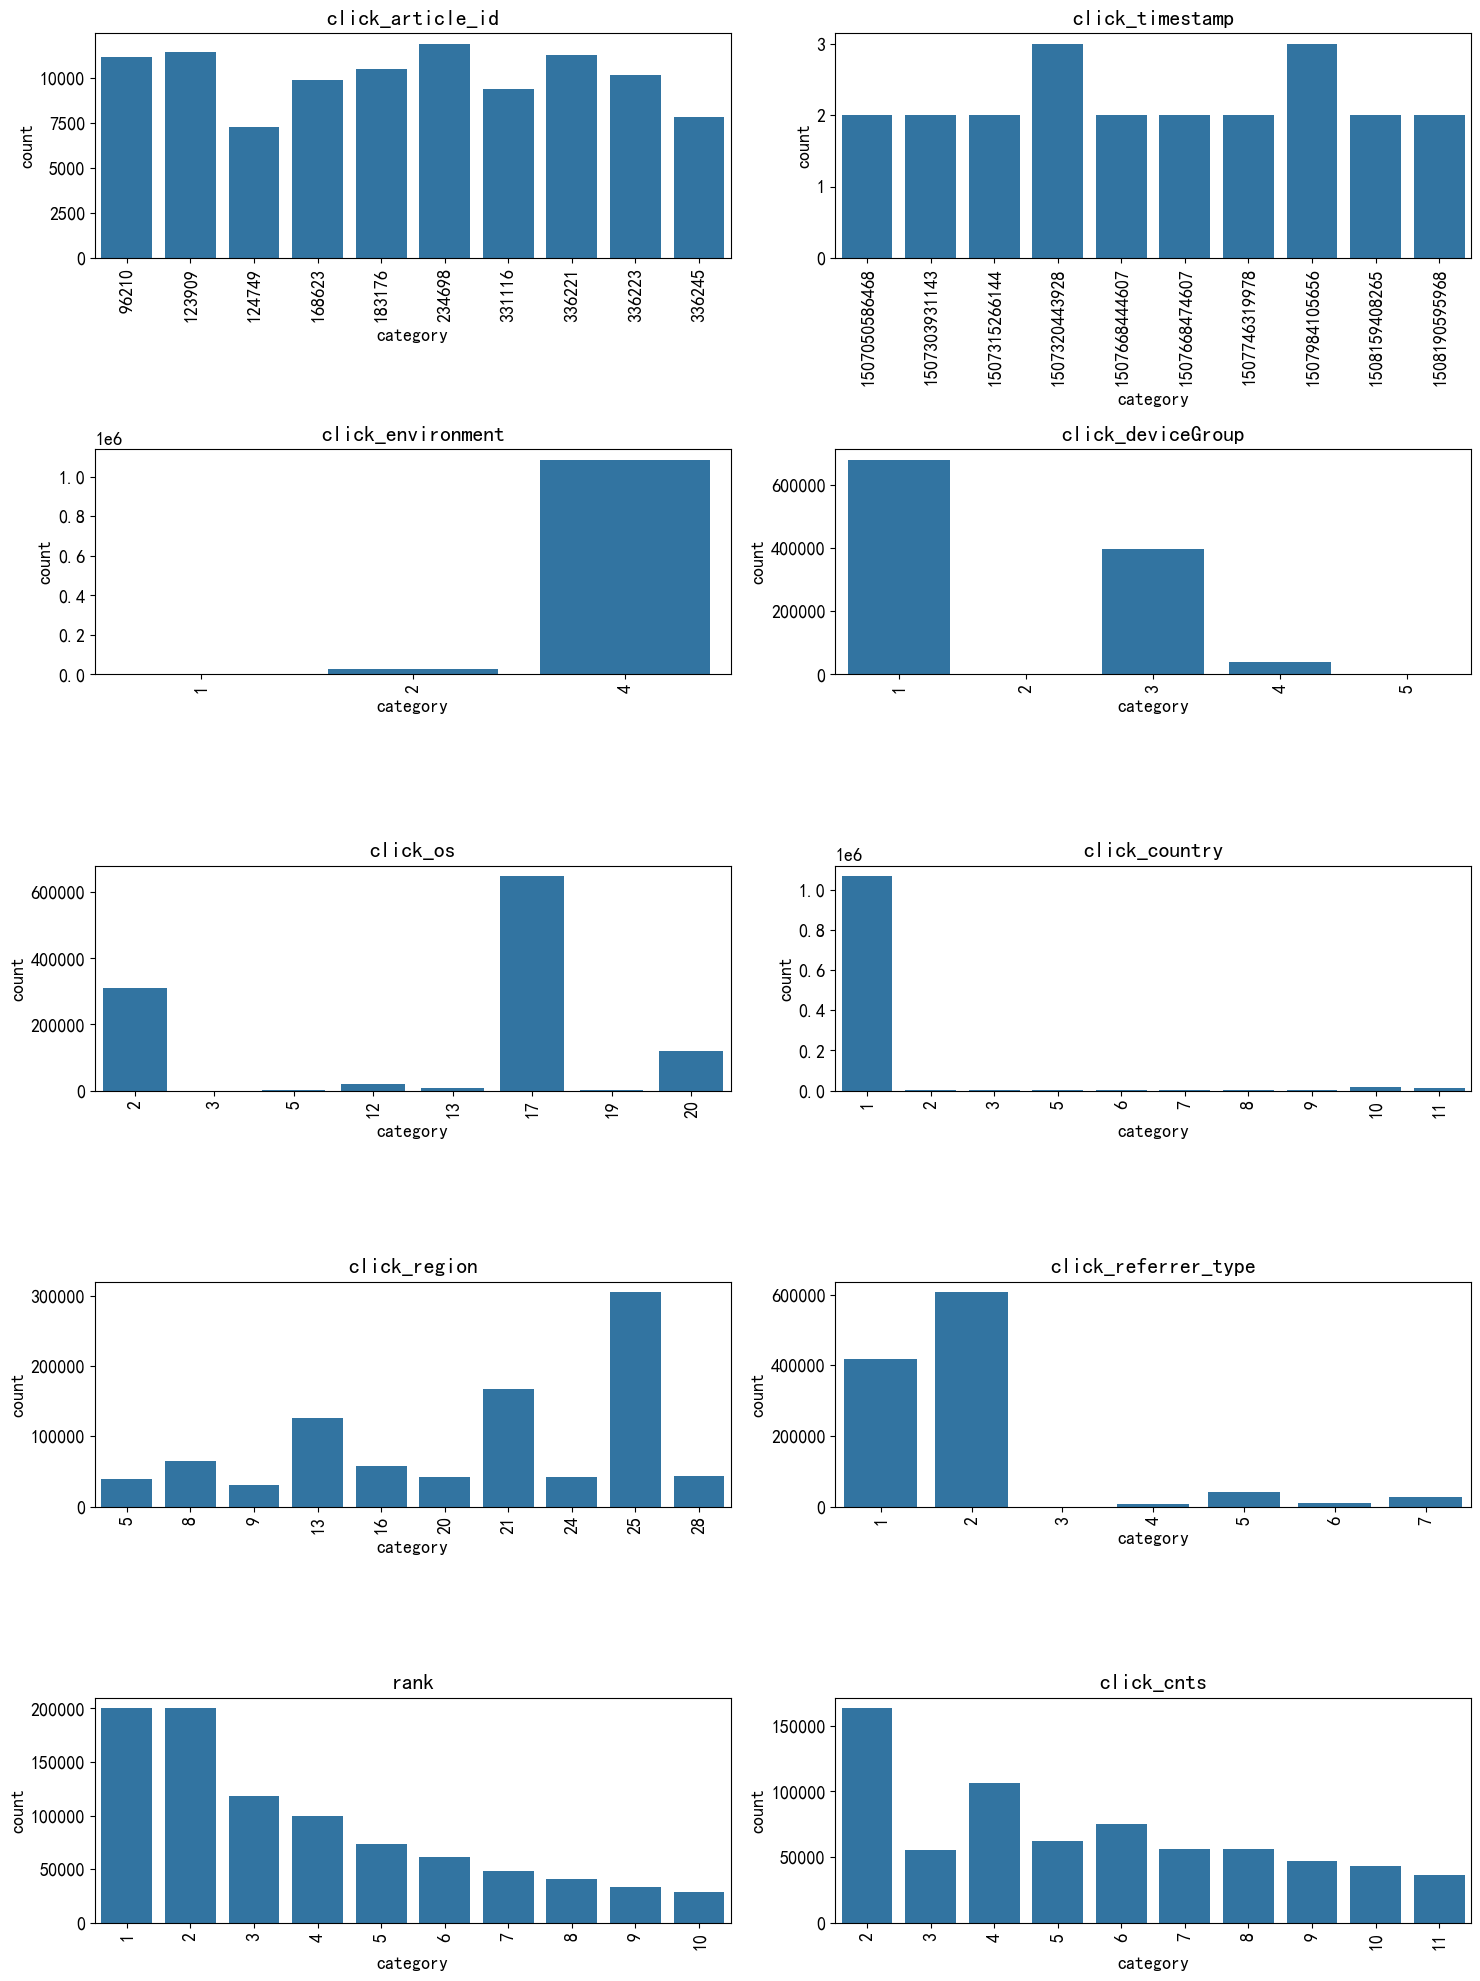

In [12]:
# 画直方图
plt.figure()
plt.figure(figsize=(15, 20))
i = 1
for col in ['click_article_id', 'click_timestamp', 'click_environment', 'click_deviceGroup', 'click_os', 'click_country', 
            'click_region', 'click_referrer_type', 'rank', 'click_cnts']:
    plot_envs = plt.subplot(5, 2, i)
    i += 1
    v = trn_click[col].value_counts().reset_index()[:10]  # 计算 top10
    v.columns = ['category', 'count']  # 明确列名，确保 `count` 代表数量

    fig = sns.barplot(x=v['category'], y=v['count'])  # 正确匹配 x 和 y
    for item in fig.get_xticklabels():
        item.set_rotation(90)
    plt.title(col)
plt.tight_layout()
plt.show()

In [11]:
#新闻文章数据集浏览
pd.concat([item_df.head(), item_df.tail()])

,click_article_id,category_id,created_at_ts,words_count
0,0,0,1513144419000,168
1,1,1,1405341936000,189
2,2,1,1408667706000,250
3,3,1,1408468313000,230
4,4,1,1407071171000,162
364042,364042,460,1434034118000,144
364043,364043,460,1434148472000,463
364044,364044,460,1457974279000,177
364045,364045,460,1515964737000,126
364046,364046,460,1505811330000,479


最早发布时间 2006-09-27 11:14:35
最晚发布时间 2018-03-13 12:12:30


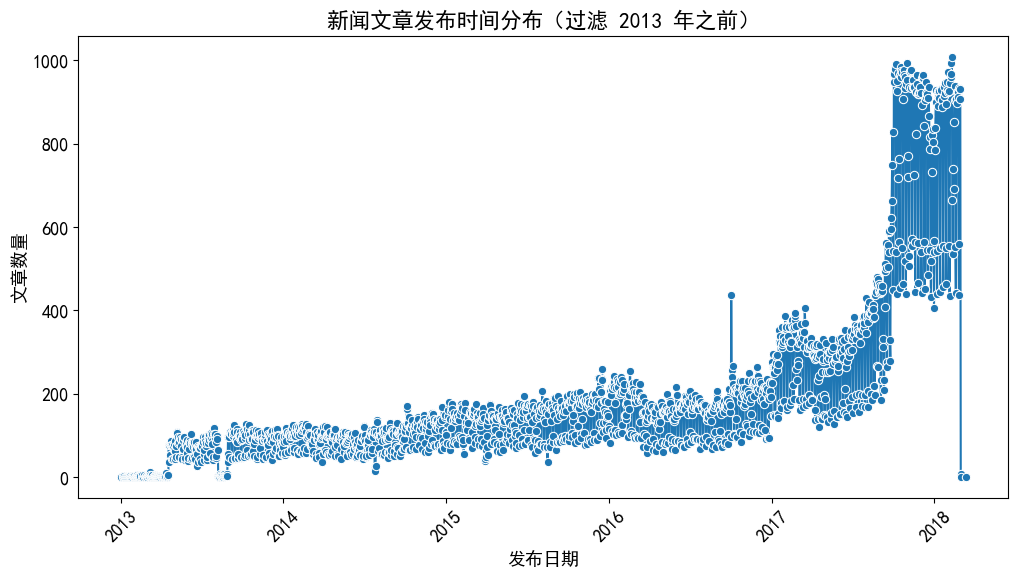

In [22]:
# 新闻文章发布时间分布
news_min_time = item_df['created_at_ts'].min()
news_max_time = item_df['created_at_ts'].max()

print("最早发布时间", pd.to_datetime(news_min_time, unit = 'ms'))
print("最晚发布时间", pd.to_datetime(news_max_time, unit = 'ms'))

# 1️⃣ 过滤掉 2013 年之前的新闻
filtered_item_df = item_df[pd.to_datetime(item_df['created_at_ts'], unit='ms') >= '2013-01-01']

# 2️⃣ 重新按日期统计新闻发布时间
filtered_item_df['creat_date'] = pd.to_datetime(filtered_item_df['created_at_ts'], unit='ms').dt.date
news_per_day = filtered_item_df.groupby('creat_date').size()

# 3️⃣ 绘制新闻发布时间的分布曲线
plt.figure(figsize=(12, 6))
sns.lineplot(x=news_per_day.index, y=news_per_day.values, marker='o')

plt.xlabel("发布日期")
plt.ylabel("文章数量")
plt.title("新闻文章发布时间分布（过滤 2013 年之前）")
plt.xticks(rotation=45)
plt.show()

最小字数 0
最大字数 6690


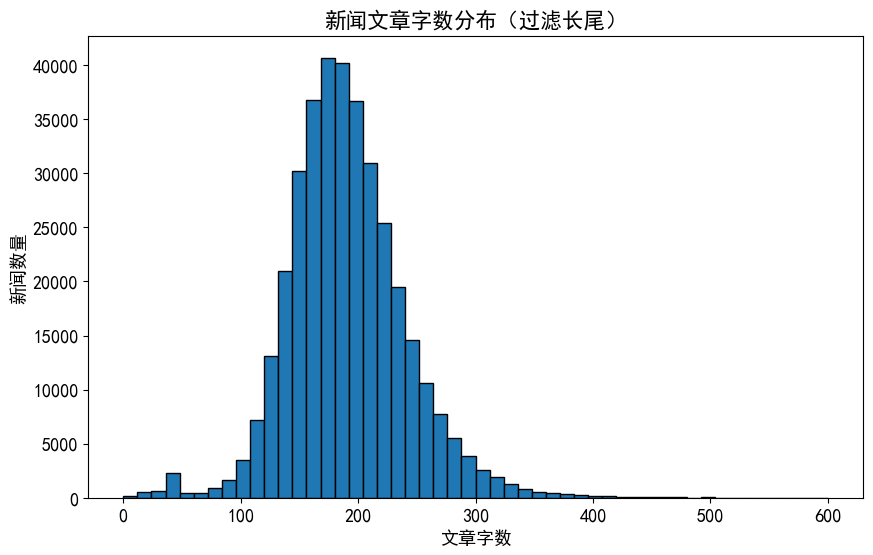

In [21]:
# 新闻文章字数分布
news_min_words_cnt = item_df['words_count'].min()
news_max_words_cnt = item_df['words_count'].max()

print("最小字数", news_min_words_cnt)
print("最大字数", news_max_words_cnt) 

news_words_count = item_df.groupby('words_count').size()
plt.figure(figsize=(10, 6))
# 过滤掉字数 > 1000 的异常数据
filtered_data = item_df[item_df['words_count'] <= 600]

plt.hist(filtered_data['words_count'], bins=50, edgecolor='black')

plt.xlabel("文章字数")
plt.ylabel("新闻数量")
plt.title("新闻文章字数分布（过滤长尾）")
plt.show()


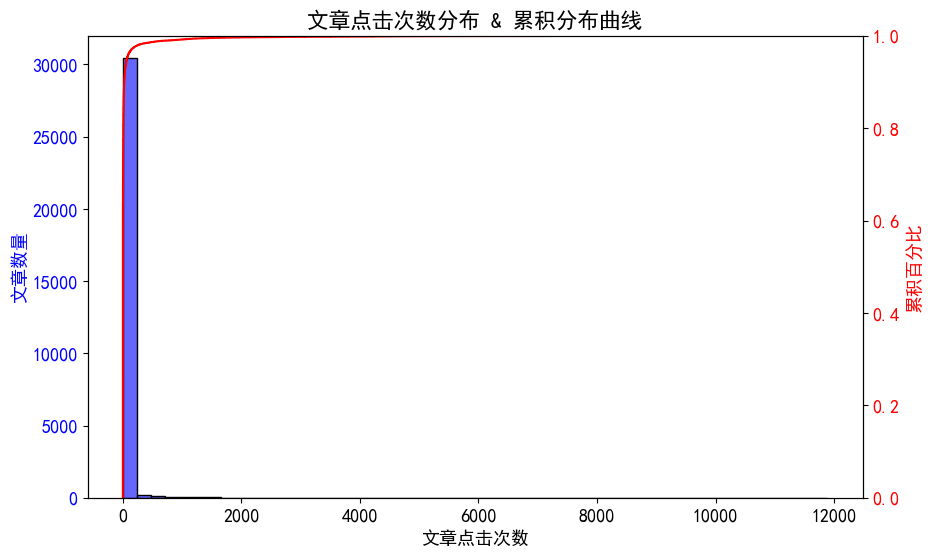

In [14]:

# 统计每篇文章的点击次数
article_click_counts = trn_click['click_article_id'].value_counts()

# 创建图形
fig, ax1 = plt.subplots(figsize=(10, 6))

# 绘制 直方图（左轴）
sns.histplot(article_click_counts, bins=50, kde=False, ax=ax1, color="blue", alpha=0.6)
ax1.set_xlabel("文章点击次数")
ax1.set_ylabel("文章数量", color="blue")
ax1.tick_params(axis='y', labelcolor="blue")

# 创建第二个 y 轴，用于绘制累计分布曲线
ax2 = ax1.twinx()
sns.ecdfplot(article_click_counts, ax=ax2, color="red")  # 叠加累积分布曲线
ax2.set_ylabel("累积百分比", color="red")
ax2.tick_params(axis='y', labelcolor="red")

plt.title("文章点击次数分布 & 累积分布曲线")
plt.show()


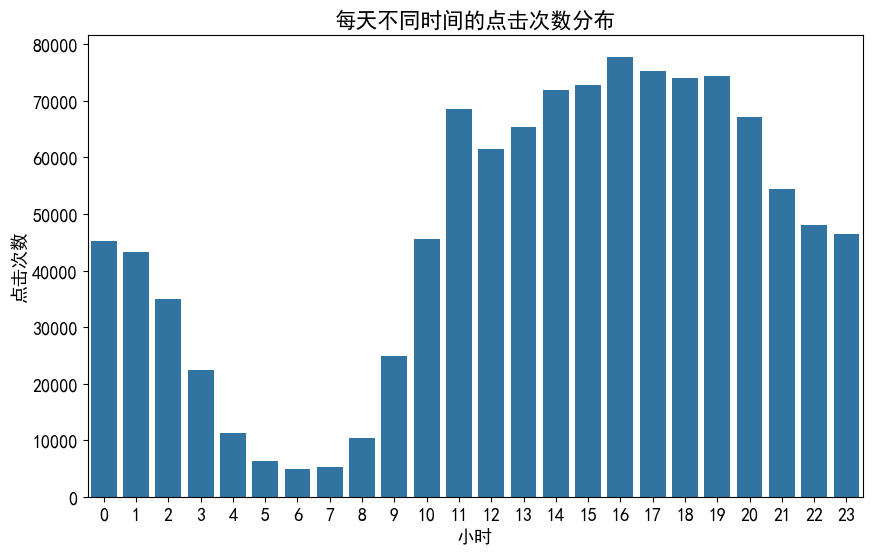

In [18]:
trn_click['click_timestamp'] = trn_click['click_timestamp'] // 1000  # 先转换为秒
trn_click['click_hour'] = pd.to_datetime(trn_click['click_timestamp'], unit='s').dt.hour
plt.figure(figsize=(10, 6))
sns.countplot(x=trn_click['click_hour'])
plt.xlabel("小时")
plt.ylabel("点击次数")
plt.title("每天不同时间的点击次数分布")
plt.show()

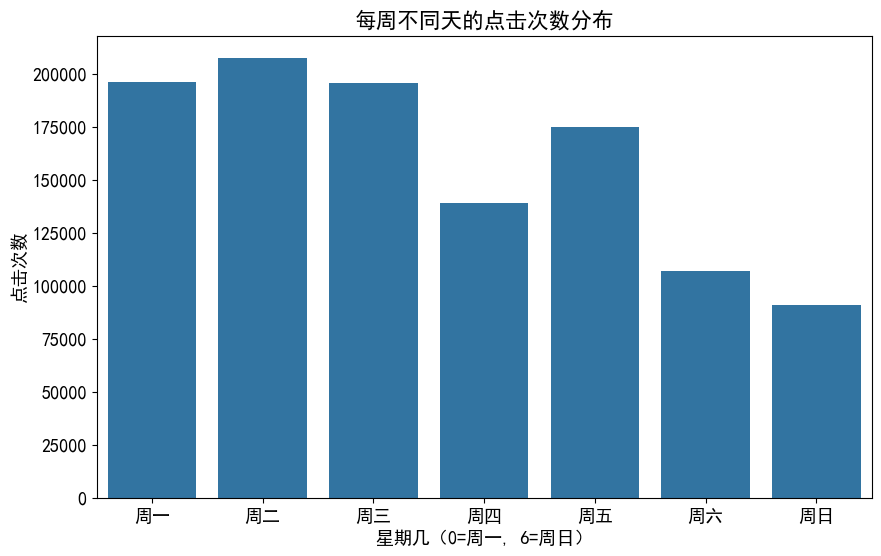

In [20]:
trn_click['click_weekday'] = pd.to_datetime(trn_click['click_timestamp'], unit='s').dt.weekday

plt.figure(figsize=(10, 6))
sns.countplot(x=trn_click['click_weekday'], order=[0, 1, 2, 3, 4, 5, 6])  # 确保按星期顺序排列
plt.xlabel("星期几（0=周一, 6=周日）")
plt.ylabel("点击次数")
plt.title("每周不同天的点击次数分布")
plt.xticks(ticks=[0, 1, 2, 3, 4, 5, 6], labels=["周一", "周二", "周三", "周四", "周五", "周六", "周日"])  # 显示中文
plt.show()

In [21]:
tst_click = tst_click.merge(item_df, how='left', on=['click_article_id'])
tst_click.describe()

,user_id,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type,rank,click_cnts,category_id,created_at_ts,words_count
count,518010.000000,518010.000000,5.180100e+05,518010.000000,518010.000000,518010.000000,518010.000000,518010.000000,518010.000000,518010.000000,518010.000000,518010.000000,5.180100e+05,518010.000000
mean,227342.428169,193803.792550,1.507387e+12,3.947300,1.738285,13.628467,1.348209,18.250250,1.819614,15.521785,30.043586,305.324961,1.506883e+12,210.966331
std,14613.907188,88279.388177,3.706127e+08,0.323916,1.020858,6.625564,1.703524,7.060798,1.082657,33.957702,56.868021,110.411513,5.816668e+09,83.040065
min,200000.000000,137.000000,1.506959e+12,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.265812e+12,0.000000
25%,214926.000000,128551.000000,1.507026e+12,4.000000,1.000000,12.000000,1.000000,13.000000,1.000000,4.000000,10.000000,252.000000,1.506970e+12,176.000000
50%,229109.000000,199197.000000,1.507308e+12,4.000000,1.000000,17.000000,1.000000,21.000000,2.000000,8.000000,19.000000,323.000000,1.507249e+12,199.000000
75%,240182.000000,272143.000000,1.507666e+12,4.000000,3.000000,17.000000,1.000000,25.000000,2.000000,18.000000,35.000000,399.000000,1.507630e+12,232.000000
max,249999.000000,364043.000000,1.508832e+12,4.000000,5.000000,20.000000,11.000000,28.000000,7.000000,938.000000,938.000000,460.000000,1.509949e+12,3082.000000


train最早时间 2017-10-03 11:18:52.200000
train最晚时间 2017-11-13 20:04:14.886000
testA最早时间 2017-10-02 15:44:10.386000
testA最晚时间 2017-10-24 07:56:58.749000


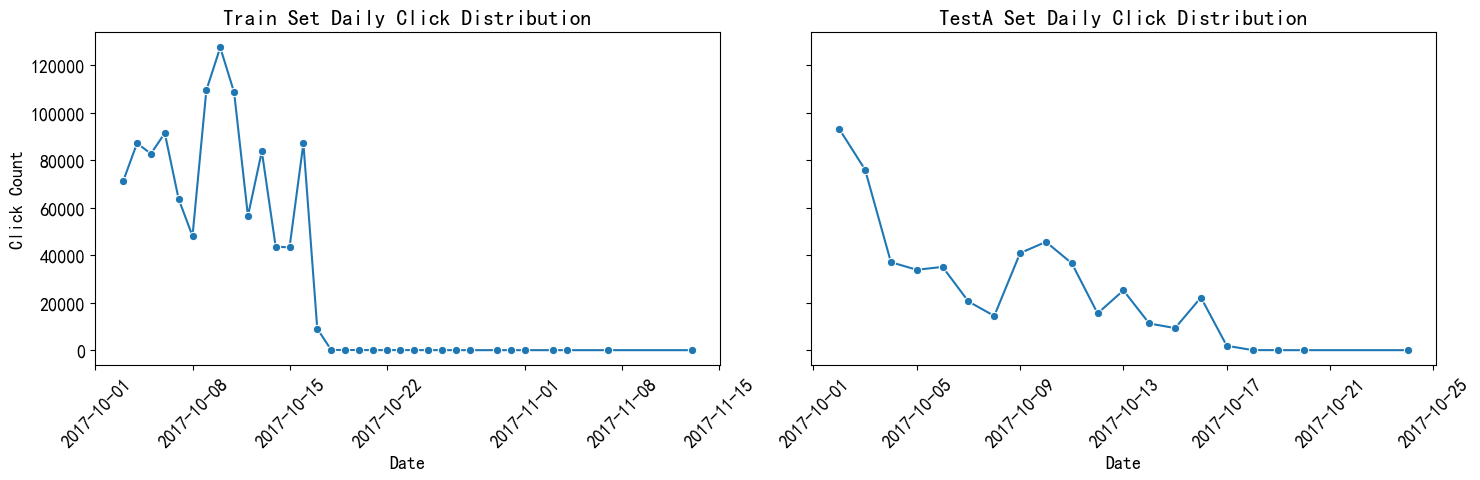

In [9]:
# 文章被点击的时间分布
trn_min_time = trn_click['click_timestamp'].min()
trn_max_time = trn_click['click_timestamp'].max()
tst_min_time = tst_click['click_timestamp'].min()
tst_max_time = tst_click['click_timestamp'].max()

print("train最早时间", pd.to_datetime(trn_min_time, unit = 'ms'))
print("train最晚时间", pd.to_datetime(trn_max_time, unit = 'ms'))
print("testA最早时间", pd.to_datetime(tst_min_time, unit = 'ms'))
print("testA最晚时间", pd.to_datetime(tst_max_time, unit = 'ms'))


# 1️⃣ 确保 click_timestamp 是毫秒时间戳，并转换为日期
trn_click['click_date'] = pd.to_datetime(trn_click['click_timestamp'], unit='ms').dt.date
tst_click['click_date'] = pd.to_datetime(tst_click['click_timestamp'], unit='ms').dt.date

# 2️⃣ 按日期统计点击量
train_clicks_per_day = trn_click.groupby('click_date').size()
testA_clicks_per_day = tst_click.groupby('click_date').size()

# 3️⃣ 绘制双子图：左边是训练集，右边是测试集 A
fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey=True)

# 📌 训练集点击趋势
sns.lineplot(ax=axes[0], x=train_clicks_per_day.index, y=train_clicks_per_day.values, marker='o')
axes[0].set_title("Train Set Daily Click Distribution")
axes[0].set_xlabel("Date")
axes[0].set_ylabel("Click Count")
axes[0].tick_params(axis='x', rotation=45)

# 📌 测试集 A 点击趋势
sns.lineplot(ax=axes[1], x=testA_clicks_per_day.index, y=testA_clicks_per_day.values, marker='o')
axes[1].set_title("TestA Set Daily Click Distribution")
axes[1].set_xlabel("Date")
axes[1].tick_params(axis='x', rotation=45)

# 4️⃣ 美化布局
plt.tight_layout()
plt.show()

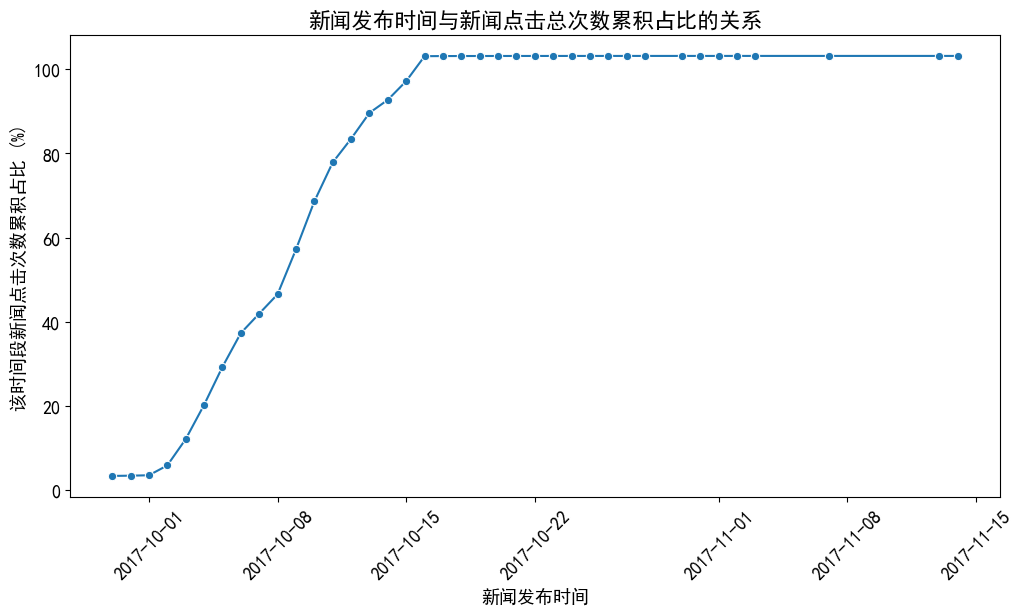

In [40]:
# 1️⃣ 确保 created_at_ts 是毫秒时间戳，并转换为日期
item_df['create_date'] = pd.to_datetime(item_df['created_at_ts'], unit='ms').dt.date

# 2️⃣ 统计每个日期发布的新闻被点击的总次数
news_clicks_per_day = trn_click.merge(item_df[['click_article_id', 'create_date']], 
                                      left_on='click_article_id', right_on='click_article_id')
news_clicks_per_day = news_clicks_per_day.groupby('create_date').size()

# 3️⃣ 过滤掉 2017-09-29 之前的数据
news_clicks_per_day = news_clicks_per_day[news_clicks_per_day.index >= pd.to_datetime('2017-09-29').date()]

# 4️⃣ 计算累积百分比
total_clicks = news_clicks_per_day.sum()
news_clicks_cumsum = news_clicks_per_day.cumsum() / total_clicks * 100

# 5️⃣ 计算 2017-09-29 之前的点击贡献，并加到累积曲线上
pre_2017_clicks = trn_click.merge(item_df[['click_article_id', 'create_date']], 
                                  left_on='click_article_id', right_on='click_article_id')
pre_2017_clicks = pre_2017_clicks[pre_2017_clicks['create_date'] < pd.to_datetime('2017-09-29').date()]
pre_2017_percentage = pre_2017_clicks.shape[0] / total_clicks * 100

news_clicks_cumsum += pre_2017_percentage  # 确保起始值包含之前文章的贡献

# 6️⃣ 绘制新闻发布时间与新闻点击总次数累积百分比的关系
plt.figure(figsize=(12,6))
sns.lineplot(x=news_clicks_cumsum.index, y=news_clicks_cumsum.values, marker='o')

plt.xlabel("新闻发布时间")
plt.ylabel("该时间段新闻点击次数累积占比 (%)")
plt.title("新闻发布时间与新闻点击总次数累积占比的关系")
plt.xticks(rotation=45)
plt.show()

In [6]:
#####merge
user_click_merge = pd.concat([trn_click, tst_click], ignore_index=True)
#用户重复点击
user_click_count = user_click_merge.groupby(['user_id', 'click_article_id'])['click_timestamp'].agg({'count'}).reset_index()
user_click_count[:10]

,user_id,click_article_id,count
0,0,30760,1
1,0,157507,1
2,1,63746,1
3,1,289197,1
4,2,36162,1
5,2,168401,1
6,3,36162,1
7,3,50644,1
8,4,39894,1
9,4,42567,1


In [7]:
user_click_count[user_click_count['count']>7]

,user_id,click_article_id,count
311242,86295,74254,10
311243,86295,76268,10
393761,103237,205948,10
393763,103237,235689,10
576902,134850,69463,13


In [8]:
user_click_count['count'].unique()

array([ 1,  2,  4,  3,  6,  5, 10,  7, 13], dtype=int64)

In [9]:
#用户点击新闻次数
user_click_count.loc[:,'count'].value_counts() 

count
1     1605541
2       11621
3         422
4          77
5          26
6          12
10          4
7           3
13          1
Name: count, dtype: int64

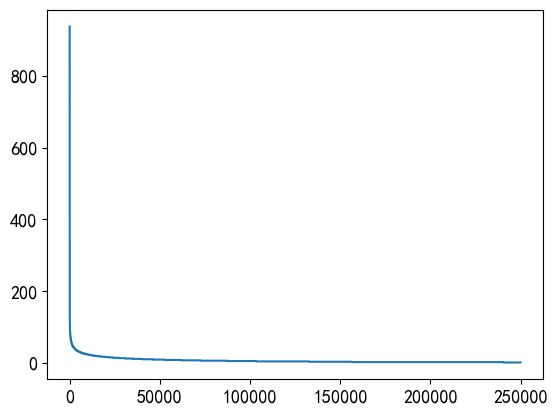

In [7]:
###用户点击新闻数量的分布
user_click_item_count = sorted(user_click_merge.groupby('user_id')['click_article_id'].count(), reverse=True)
plt.plot(user_click_item_count)

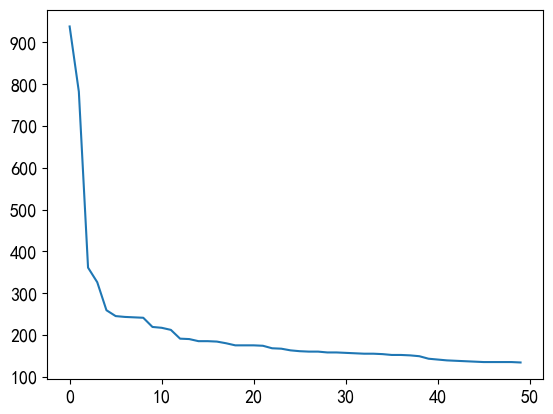

In [8]:
#点击次数在前50的用户
plt.plot(user_click_item_count[:50])

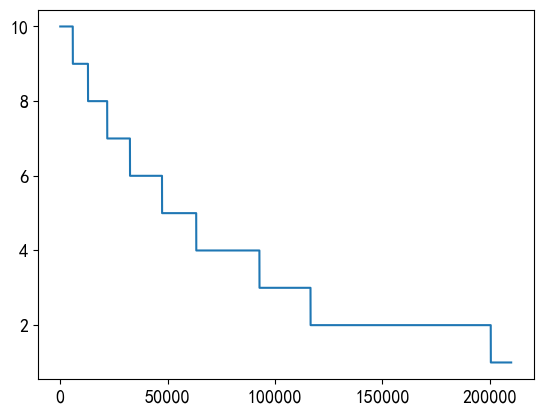

In [19]:
#点击次数排名在[25000:50000]之间
plt.plot(user_click_item_count[40000:250000])

In [20]:
item_click_count = sorted(user_click_merge.groupby('click_article_id')['user_id'].count(), reverse=True)

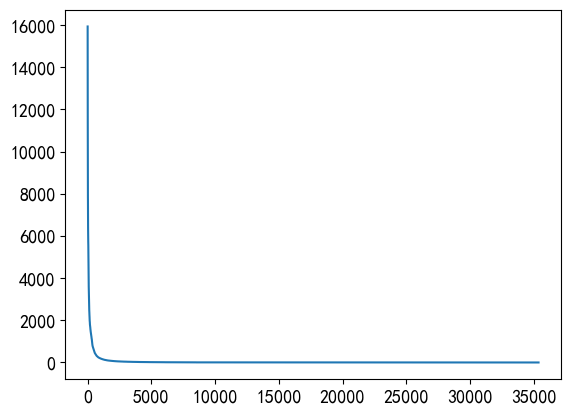

In [21]:
plt.plot(item_click_count)

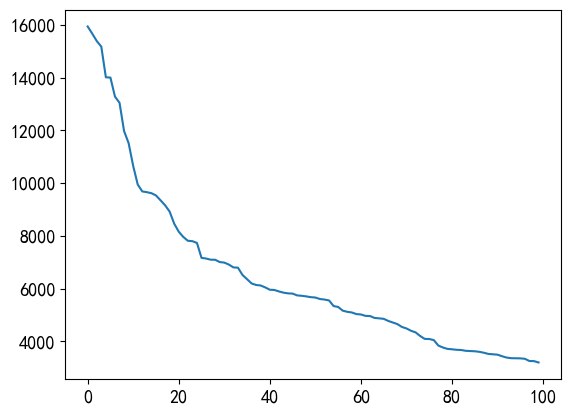

In [22]:
plt.plot(item_click_count[:100])

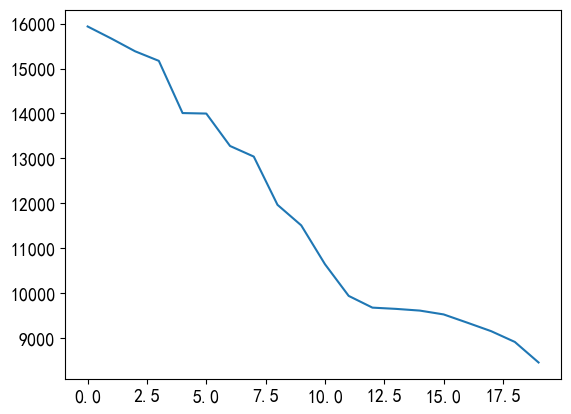

In [23]:
plt.plot(item_click_count[:20])

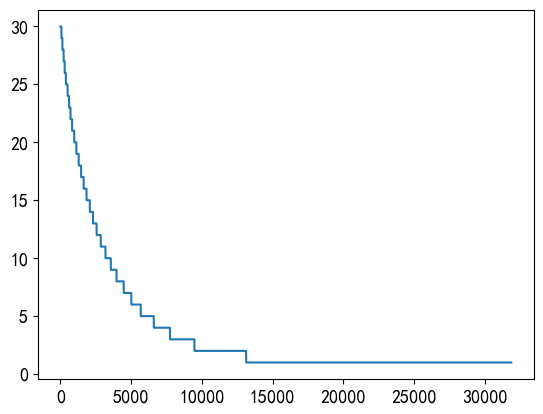

In [24]:
plt.plot(item_click_count[3500:])

In [25]:
tmp = user_click_merge.sort_values('click_timestamp') 
tmp['next_item'] = tmp.groupby(['user_id'])['click_article_id'].transform(lambda x:x.shift(-1))
union_item = tmp.groupby(['click_article_id','next_item'])['click_timestamp'].agg({'count'}).reset_index().sort_values('count', ascending=False)
union_item[['count']].describe()

,count
count,433597.000000
mean,3.184139
std,18.851753
min,1.000000
25%,1.000000
50%,1.000000
75%,2.000000
max,2202.000000


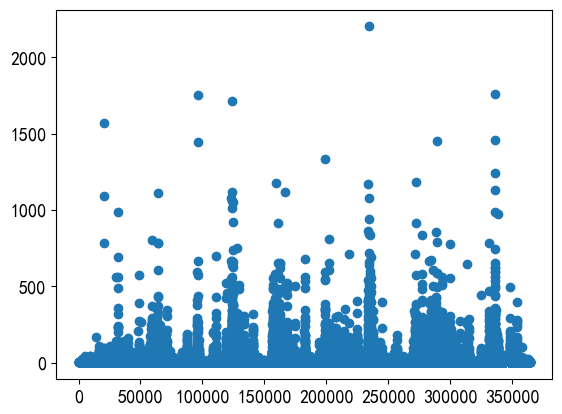

In [26]:
#画个图直观地看一看
x = union_item['click_article_id']
y = union_item['count']
plt.scatter(x, y)

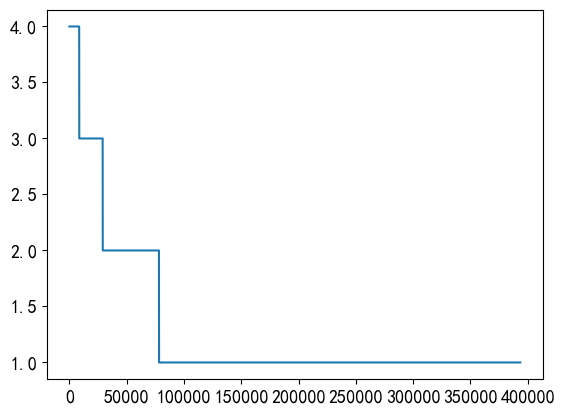

In [27]:
plt.plot(union_item['count'].values[40000:])

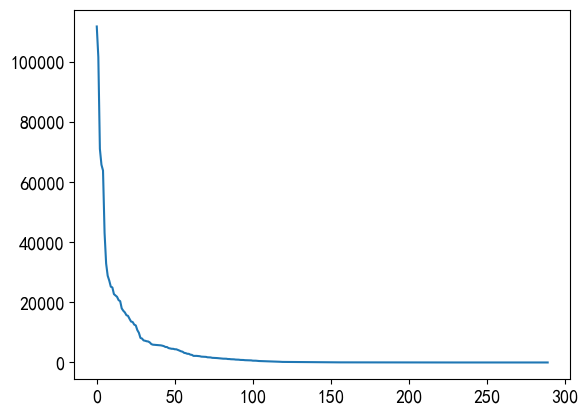

In [28]:
#不同类型的新闻出现的次数
plt.plot(user_click_merge['category_id'].value_counts().values)

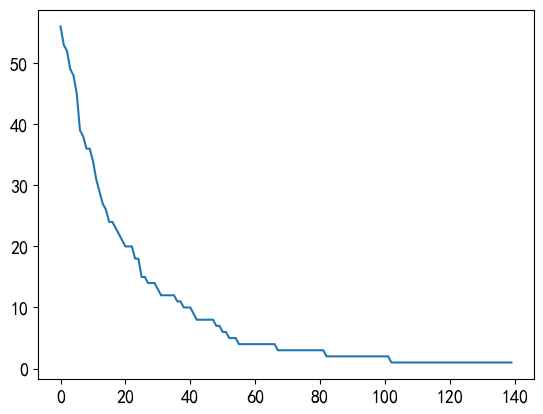

In [29]:
#出现次数比较少的新闻类型, 有些新闻类型，基本上就出现过几次
plt.plot(user_click_merge['category_id'].value_counts().values[150:])

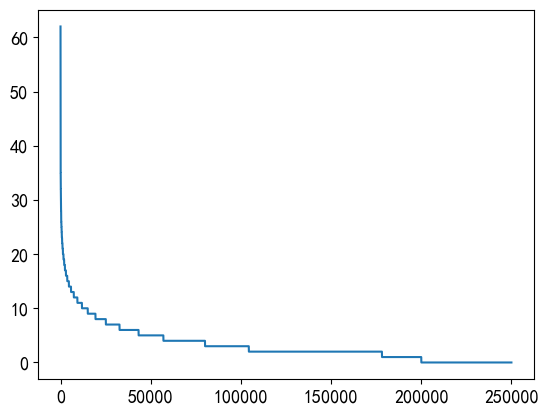

In [30]:
plt.plot(sorted(user_click_merge.groupby('user_id')['category_id'].nunique(), reverse=True))

In [31]:
user_click_merge.groupby('user_id')['category_id'].nunique().reset_index().describe()

,user_id,category_id
count,250000.000000,250000.000000
mean,124999.500000,3.256964
std,72168.927986,3.647648
min,0.000000,0.000000
25%,62499.750000,1.000000
50%,124999.500000,2.000000
75%,187499.250000,4.000000
max,249999.000000,62.000000


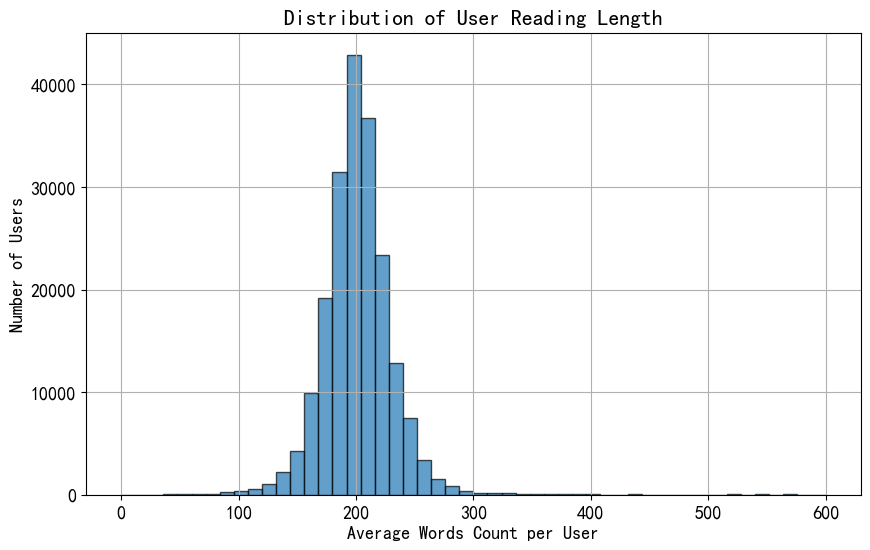

In [36]:
import matplotlib.pyplot as plt

# 计算每个用户的平均阅读字数
user_words_mean = user_click_merge.groupby('user_id')['words_count'].mean()

# 绘制直方图
plt.figure(figsize=(10, 6))
plt.hist(user_words_mean, bins=50, range=(0, 600), edgecolor='black', alpha=0.7)
plt.xlabel('Average Words Count per User')
plt.ylabel('Number of Users')
plt.title('Distribution of User Reading Length')
plt.grid(True)
plt.show()

In [37]:
#更加详细的参数
user_click_merge.groupby('user_id')['words_count'].mean().reset_index().describe()

,user_id,words_count
count,250000.000000,200000.000000
mean,124999.500000,201.307200
std,72168.927986,32.694738
min,0.000000,16.000000
25%,62499.750000,185.000000
50%,124999.500000,200.500000
75%,187499.250000,216.050658
max,249999.000000,3434.500000
